   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

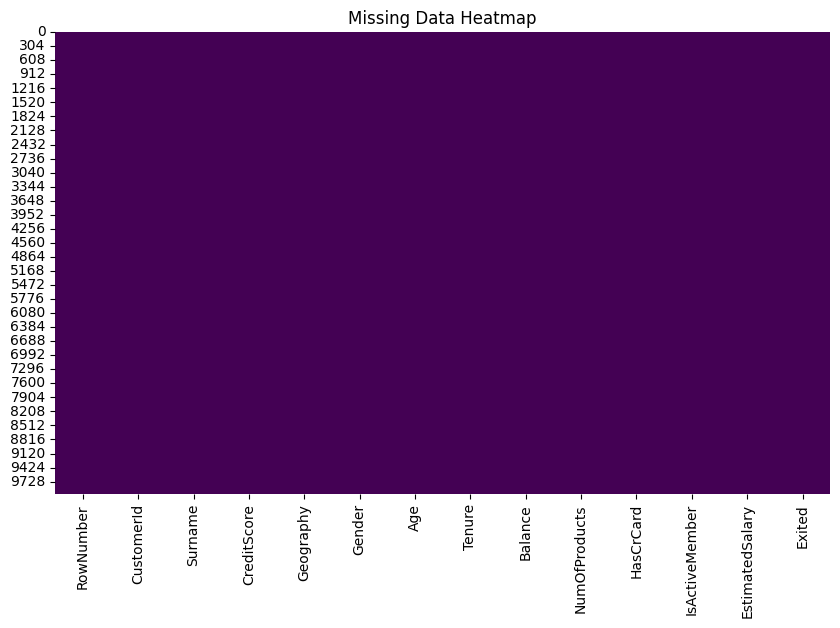

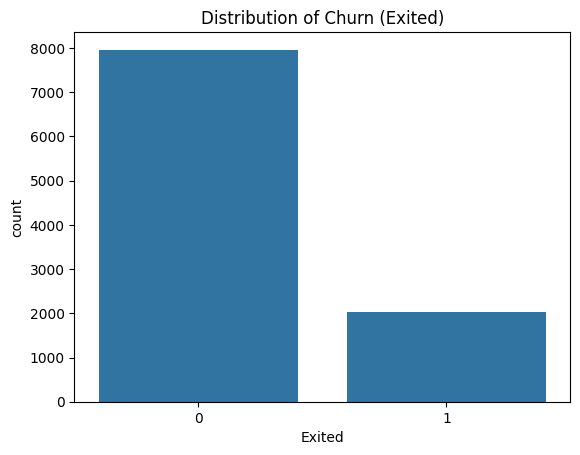

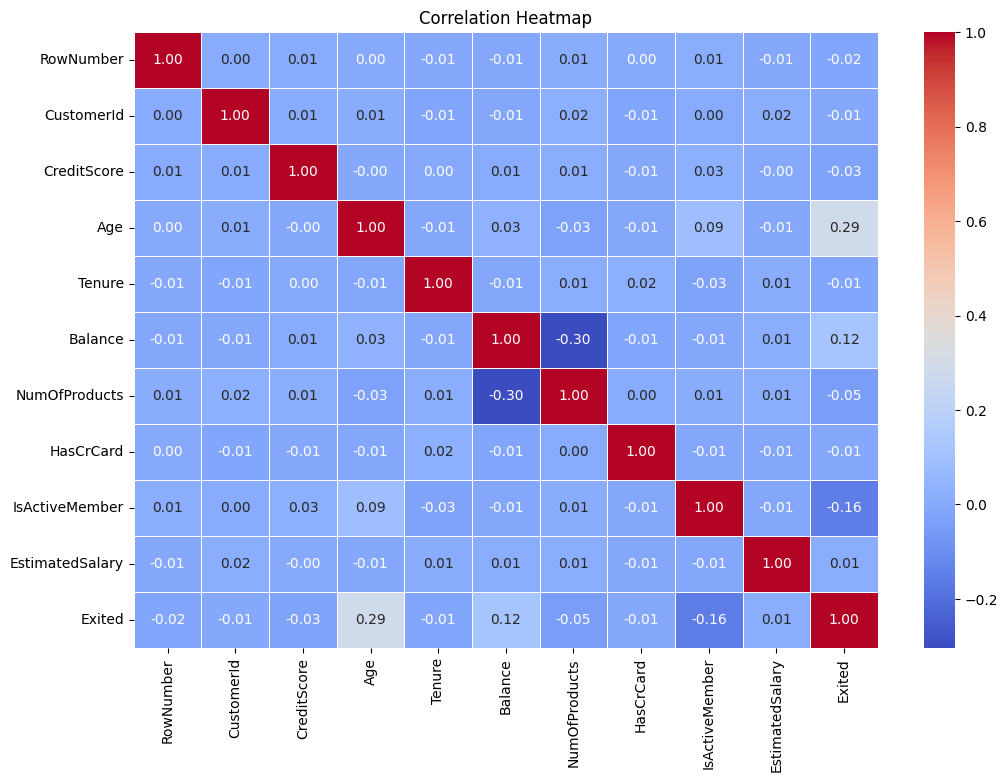

LogisticRegression - Accuracy: 0.8150, ROC AUC: 0.7636
LogisticRegression - Confusion Matrix:
 [[1559   48]
 [ 322   71]]
LogisticRegression - Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

RandomForest - Accuracy: 0.8635, ROC AUC: 0.8576
RandomForest - Confusion Matrix:
 [[1549   58]
 [ 215  178]]
RandomForest - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.45      0.57       393

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000

SVM - Accuracy: 0.8260, ROC AU

['churn_model.pkl']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans  # For unsupervised model

# Load the dataset
df = pd.read_csv('Churn_Modelling.csv')

# Problem Definition and Dataset Analysis
print(df.head())
print(df.info())
print(df.describe())

# Visualizing missing data (if any)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Visualize distribution of the target variable 'Exited'
sns.countplot(x='Exited', data=df)
plt.title('Distribution of Churn (Exited)')
plt.show()

# Correlation heatmap to observe relationships between features
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Only numeric columns for correlation
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing
# Drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Encode 'Geography' and 'Gender' with separate label encoders
label_encoder_geography = LabelEncoder()
df['Geography'] = label_encoder_geography.fit_transform(df['Geography'])

label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])

# Standardize features
scaler = StandardScaler()
columns_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Save label encoders and scaler for later use in deployment
joblib.dump(label_encoder_geography, 'label_encoder_geography.pkl')
joblib.dump(label_encoder_gender, 'label_encoder_gender.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save column order
columns_order = df.drop('Exited', axis=1).columns  # Save the order of features excluding the target
joblib.dump(columns_order, 'columns_order.pkl')

# Splitting the data into training and testing sets
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to be used
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'KMeans': KMeans(n_clusters=2),  # Unsupervised model for clustering
    'GradientBoosting': GradientBoostingClassifier()  # Adding Gradient Boosting
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if model supports predict_proba() and calculate ROC AUC
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        roc_auc = None
    
    # Print results
    if roc_auc is not None:
        print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    else:
        print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC AUC: N/A")
    
    # Confusion Matrix and Classification Report
    print(f"{model_name} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=kf)
    print(f"{model_name} - Cross-validation mean accuracy: {cv_scores.mean():.4f}")

# Save the trained model, scaler, and label encoder for Geography and Gender
joblib.dump(models['RandomForest'], 'churn_model.pkl')  # Save the trained model (RandomForest in this case)
